In [1]:
import sys
import os
from dotenv import load_dotenv

import numpy as np
import pandas as pd
import sqlalchemy as sq
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport
from imblearn.over_sampling import RandomOverSampler

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc

import tensorflow
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

sys.path.append("../Shared/")
from DataService import DataService

/tmp/ipykernel_357813/4293096832.py:10: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport
2023-07-04 09:31:03.463632: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-04 09:31:03.957145: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# fetch data from db

In [2]:
# function to update logs
def updateLog(fileName: str, message: str) -> None:
    try:
        if fileName is not None:
            with open(fileName, "a") as log:
                log.write(message + "\n")
    except Exception as e:
        print(message)

In [3]:
LOG_FILE = "/data/pull_moisture.log"

load_dotenv()
PG_USER = os.getenv("POSTGRES_USER")
PG_PW = os.getenv("POSTGRES_PW")
PG_DB = os.getenv("POSTGRES_DB")
PG_ADDR = os.getenv("POSTGRES_ADDR")
PG_PORT = os.getenv("POSTGRES_PORT")

In [4]:
if (
    PG_DB is None
    or PG_ADDR is None
    or PG_PORT is None
    or PG_USER is None
    or PG_PW is None
):
    updateLog(LOG_FILE, "Missing database credentials")
    raise ValueError("Environment variables are not set")
else:
    # connicting to database
    db = DataService(PG_DB, PG_ADDR, int(PG_PORT), PG_USER, PG_PW)
    conn = db.connect()

In [5]:
# pulling soil moisture data
query = sq.text("select * FROM public.agg_soil_moisture")
sm_df = pd.read_sql(query, conn)

In [6]:
sm_df.drop(columns=["index", "cr_num", "month", "day"], inplace=True)
sm_df.head()
# sm_df.duplicated().sum() # 0
# print(sm_df.shape) #117221

,year,district,soil_moisture_min,soil_moisture_max,soil_moisture_mean
0,1978,4612,0.165900,0.418710,0.237053
1,1978,4740,0.127140,0.207248,0.163722
2,1978,4741,0.153398,0.215304,0.170989
3,1978,4770,0.140772,0.186390,0.152211
4,1978,4771,0.116810,0.116810,0.116810


In [7]:
sm_df = sm_df.drop_duplicates()

In [19]:
# pull ergot data
query = sq.text("select * FROM public.agg_ergot_samples")
ergot_df = pd.read_sql(query, conn)

In [20]:
ergot_df.shape

(1092, 13)

0

In [21]:
ergot_df.sample(5)

,year,district,percnt_true,has_ergot,sum_severity,present_prev1,present_prev2,present_prev3,present_in_neighbor,severity_prev1,severity_prev2,severity_prev3,severity_in_neighbor
729,2013,4741,0.162791,True,0.11,True,True,True,True,0.016949,0.222222,0.011765,0.250000
1022,2021,4602,0.000000,False,0.00,True,True,True,True,0.369048,0.247788,0.350365,0.015801
18,1995,4710,0.023936,True,29.00,False,False,False,True,0.000000,0.000000,0.000000,0.015261
394,2005,4850,0.084337,True,0.08,True,True,True,True,0.089286,0.291667,0.033898,0.032911
104,1997,4740,0.000000,False,0.00,False,False,False,True,0.000000,0.000000,0.000000,0.001170


In [15]:
ergot_df["has_ergot"].value_counts()

True     881
False    211
Name: has_ergot, dtype: int64

In [22]:
ergot_df.drop(columns=["sum_severity", "present_in_neighbor", "severity_in_neighbor"], inplace=True)

In [23]:
ergot_df.duplicated().sum()

0

In [71]:
ergot_df = ergot_df.drop_duplicates()

In [72]:
ergot_df.sample(5)

,year,province,crop_district,district,percnt_true,has_ergot,present_prev1,present_prev2,present_prev3,severity_prev1,severity_prev2,severity_prev3
83158,2006,SK,22,4721,0.018293,True,True,True,True,0.106383,0.058824,0.113095
92106,2008,SK,12,4711,0.207547,True,True,True,True,0.011628,0.039216,0.085714
96654,2009,MB,11,4611,1.000000,True,False,False,False,0.000000,0.000000,0.000000
88323,2007,MB,5,4605,0.015625,True,True,True,True,0.024390,0.160494,0.025000
45461,1999,SK,41,4740,0.048780,True,False,False,False,0.000000,0.000000,0.000000


In [24]:
ergot_df.shape

(1092, 10)

True     881
False    182
Name: has_ergot, dtype: int64

In [25]:
# pull weather data
# in case reading csv
weather_df = pd.read_csv("data/aggregatedDly.csv")
weather_df.shape

(1064, 5478)

In [26]:
weather_df

,Unnamed: 0,year,district,01-01:max_temp,01-01:min_temp,01-01:mean_temp,01-01:min_total_rain,01-01:max_total_rain,01-01:mean_total_rain,01-01:min_total_snow,...,12-31:mean_total_rain,12-31:min_total_snow,12-31:max_total_snow,12-31:mean_total_snow,12-31:min_total_precip,12-31:max_total_precip,12-31:mean_total_precip,12-31:min_snow_on_grnd,12-31:max_snow_on_grnd,12-31:mean_snow_on_grnd
0,0,1995,4860,-8.0375,-20.200000,-14.137500,0.0,0.0,0.0,0.0,...,0.0,0.0,7.3,1.70,0.0,1.5,0.444444,0.0,36.0,16.333333
1,1,1995,4810,-7.4200,-17.000000,-12.220000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.000000,0.0,19.0,6.600000
2,2,1995,4840,-8.3000,-19.425000,-13.875000,0.0,0.0,0.0,0.0,...,0.0,0.0,2.9,1.52,0.0,7.7,2.280000,0.0,24.0,8.800000
3,3,1995,4830,-5.7500,-20.258333,-13.033333,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,5.1,0.392308,0.0,28.0,5.615385
4,4,1995,4731,-7.3000,-19.650000,-13.500000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.000000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1059,1059,2022,4605,-28.3000,-33.000000,-30.700000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.000000,27.0,27.0,27.000000
1060,1060,2022,4720,-24.8000,-36.900000,-30.850000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.1,0.050000,23.0,34.0,28.500000
1061,1061,2022,4611,-25.8000,-35.600000,-30.700000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.1,0.1,0.100000,14.0,14.0,14.000000
1062,1062,2022,4751,-22.9000,-33.600000,-28.300000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.000000,6.0,6.0,6.000000


In [27]:
weather_df.drop(weather_df.columns[0], axis=1, inplace=True)

In [28]:
all_col = weather_df.columns.tolist()
uni_col = set()
for i in range (2,len(all_col)):
    # print(all_col[i].split(":")[1])
    uni_col.add(all_col[i].split(":")[1])

In [29]:
uni_col

{'max_snow_on_grnd',
 'max_temp',
 'max_total_precip',
 'max_total_rain',
 'max_total_snow',
 'mean_snow_on_grnd',
 'mean_temp',
 'mean_total_precip',
 'mean_total_rain',
 'mean_total_snow',
 'min_snow_on_grnd',
 'min_temp',
 'min_total_precip',
 'min_total_rain',
 'min_total_snow'}

In [30]:
for col_name in uni_col:
    # col_name = "max_temp"
    fil_col = weather_df.filter(like=col_name)
    weather_df[col_name] = fil_col.mean(axis=1)
    weather_df.drop(columns=fil_col.columns, inplace=True)

In [31]:
weather_df

,year,district,max_total_rain,mean_total_precip,mean_temp,mean_total_snow,min_snow_on_grnd,mean_snow_on_grnd,min_total_precip,max_total_snow,min_total_snow,min_temp,mean_total_rain,max_snow_on_grnd,max_total_precip,min_total_rain,max_temp
0,1995,4860,2.608767,1.189348,0.451735,0.303979,0.000000,6.005903,0.009589,1.438356,0.000000,-5.342542,0.529384,14.356164,4.561918,0.00000,6.238637
1,1995,4810,1.224110,0.871078,4.239744,0.116534,0.000000,0.860822,0.049589,0.416438,0.000000,-2.249689,0.328105,2.334247,2.528767,0.00000,10.713096
2,1995,4840,1.018630,0.790694,1.628772,0.155237,0.175342,3.564932,0.064110,0.565479,0.000000,-4.348895,0.250507,7.876712,2.203836,0.00000,7.595941
3,1995,4830,2.089863,1.299196,3.060292,0.135583,0.000000,1.054999,0.001918,1.108219,0.000000,-3.321827,0.332711,6.394521,5.339178,0.00000,9.424064
4,1995,4731,0.157260,0.908037,2.796575,0.010502,0.002740,0.010959,0.618356,0.016438,0.005479,-2.909954,0.078265,0.019178,1.211233,0.00274,8.491324
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1059,2022,4605,0.000000,1.151507,0.777808,0.000000,14.356164,14.356164,1.151507,0.000000,0.000000,-4.997808,0.000000,14.356164,1.151507,0.00000,6.552603
1060,2022,4720,0.000000,1.097808,2.653288,0.000000,4.482192,6.519178,0.786027,0.000000,0.000000,-3.850137,0.000000,8.556164,1.409589,0.00000,9.157397
1061,2022,4611,0.000000,2.099726,1.931507,0.000000,5.945205,5.945205,2.099726,0.000000,0.000000,-3.437808,0.000000,5.945205,2.099726,0.00000,7.302466
1062,2022,4751,0.000000,1.102466,1.386849,0.000000,5.210959,5.210959,1.102466,0.000000,0.000000,-3.926301,0.000000,5.210959,1.102466,0.00000,6.706301


In [32]:
df = pd.merge(ergot_df, weather_df,  on=["year", "district"], how="left")

In [33]:
df.isna().sum()

year                  0
district              0
percnt_true           0
has_ergot             0
present_prev1         0
present_prev2         0
present_prev3         0
severity_prev1        0
severity_prev2        0
severity_prev3        0
max_total_rain       28
mean_total_precip    28
mean_temp            28
mean_total_snow      28
min_snow_on_grnd     28
mean_snow_on_grnd    28
min_total_precip     28
max_total_snow       28
min_total_snow       28
min_temp             28
mean_total_rain      28
max_snow_on_grnd     28
max_total_precip     28
min_total_rain       28
max_temp             28
dtype: int64

In [34]:
df.interpolate(method="linear", limit_direction="both", inplace=True)

In [35]:
df = pd.merge(df, sm_df, on=["year", "district"], how="left")

In [36]:
df.isna().sum()

year                    0
district                0
percnt_true             0
has_ergot               0
present_prev1           0
present_prev2           0
present_prev3           0
severity_prev1          0
severity_prev2          0
severity_prev3          0
max_total_rain          0
mean_total_precip       0
mean_temp               0
mean_total_snow         0
min_snow_on_grnd        0
mean_snow_on_grnd       0
min_total_precip        0
max_total_snow          0
min_total_snow          0
min_temp                0
mean_total_rain         0
max_snow_on_grnd        0
max_total_precip        0
min_total_rain          0
max_temp                0
soil_moisture_min     819
soil_moisture_max     819
soil_moisture_mean    819
dtype: int64

In [37]:
df.interpolate(method="linear", limit_direction="both", inplace=True)

In [38]:
df.shape

(65850, 28)

In [28]:
# # joining tables
# # df = pd.merge(sm_df, ergot_df, how="inner", on=["year", "district"])
# df = pd.merge(sm_df, ergot_df)

In [29]:
# df.shape

In [30]:
# df = pd.merge(df, weather_df, on=["year", "district"])

In [31]:
# df.shape

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65850 entries, 0 to 65849
Data columns (total 28 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   year                65850 non-null  int64  
 1   district            65850 non-null  int64  
 2   percnt_true         65850 non-null  float64
 3   has_ergot           65850 non-null  bool   
 4   present_prev1       65850 non-null  bool   
 5   present_prev2       65850 non-null  bool   
 6   present_prev3       65850 non-null  bool   
 7   severity_prev1      65850 non-null  float64
 8   severity_prev2      65850 non-null  float64
 9   severity_prev3      65850 non-null  float64
 10  max_total_rain      65850 non-null  float64
 11  mean_total_precip   65850 non-null  float64
 12  mean_temp           65850 non-null  float64
 13  mean_total_snow     65850 non-null  float64
 14  min_snow_on_grnd    65850 non-null  float64
 15  mean_snow_on_grnd   65850 non-null  float64
 16  min_

In [40]:
df

,year,district,percnt_true,has_ergot,present_prev1,present_prev2,present_prev3,severity_prev1,severity_prev2,severity_prev3,...,min_total_snow,min_temp,mean_total_rain,max_snow_on_grnd,max_total_precip,min_total_rain,max_temp,soil_moisture_min,soil_moisture_max,soil_moisture_mean
0,1995,4810,0.000000,False,False,False,False,0.000000,0.000000,0.000000,...,0.0,-2.249689,0.328105,2.334247,2.528767,0.0,10.713096,0.14156,0.170067,0.150656
1,1995,4820,0.000000,False,False,False,False,0.000000,0.000000,0.000000,...,0.0,-2.722112,0.179473,1.893151,2.484110,0.0,10.926306,0.14156,0.170067,0.150656
2,1995,4830,0.010582,True,False,False,False,0.000000,0.000000,0.000000,...,0.0,-3.321827,0.332711,6.394521,5.339178,0.0,9.424064,0.14156,0.170067,0.150656
3,1995,4840,0.006017,True,False,False,False,0.000000,0.000000,0.000000,...,0.0,-4.348895,0.250507,7.876712,2.203836,0.0,7.595941,0.14156,0.170067,0.150656
4,1995,4850,0.006369,True,False,False,False,0.000000,0.000000,0.000000,...,0.0,-3.251098,0.531016,6.632877,3.216986,0.0,7.987340,0.14156,0.170067,0.150656
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65845,2022,4761,0.224490,True,True,True,True,0.010204,0.076923,0.062893,...,0.0,-3.774612,0.000000,5.383562,1.409589,0.0,8.882808,0.28157,0.281570,0.281570
65846,2022,4771,0.333333,True,False,True,True,0.000000,0.153333,0.013072,...,0.0,-4.853699,0.000000,3.216438,0.877260,0.0,7.748219,0.28157,0.281570,0.281570
65847,2022,4790,0.226891,True,True,True,True,0.025316,0.229167,0.147727,...,0.0,-5.284676,0.087452,19.868493,2.948767,0.0,7.079132,0.28157,0.281570,0.281570
65848,2022,4791,0.397260,True,True,True,True,0.028986,0.223881,0.328571,...,0.0,-5.094840,0.000000,19.161644,2.443288,0.0,7.411553,0.28157,0.281570,0.281570


In [34]:
# temp = pd.merge(ergot_df, weather_df)
# temp.columns

In [35]:
# g = sns.pairplot(temp.sample(1000))

/tmp/ipykernel_340236/3641604358.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


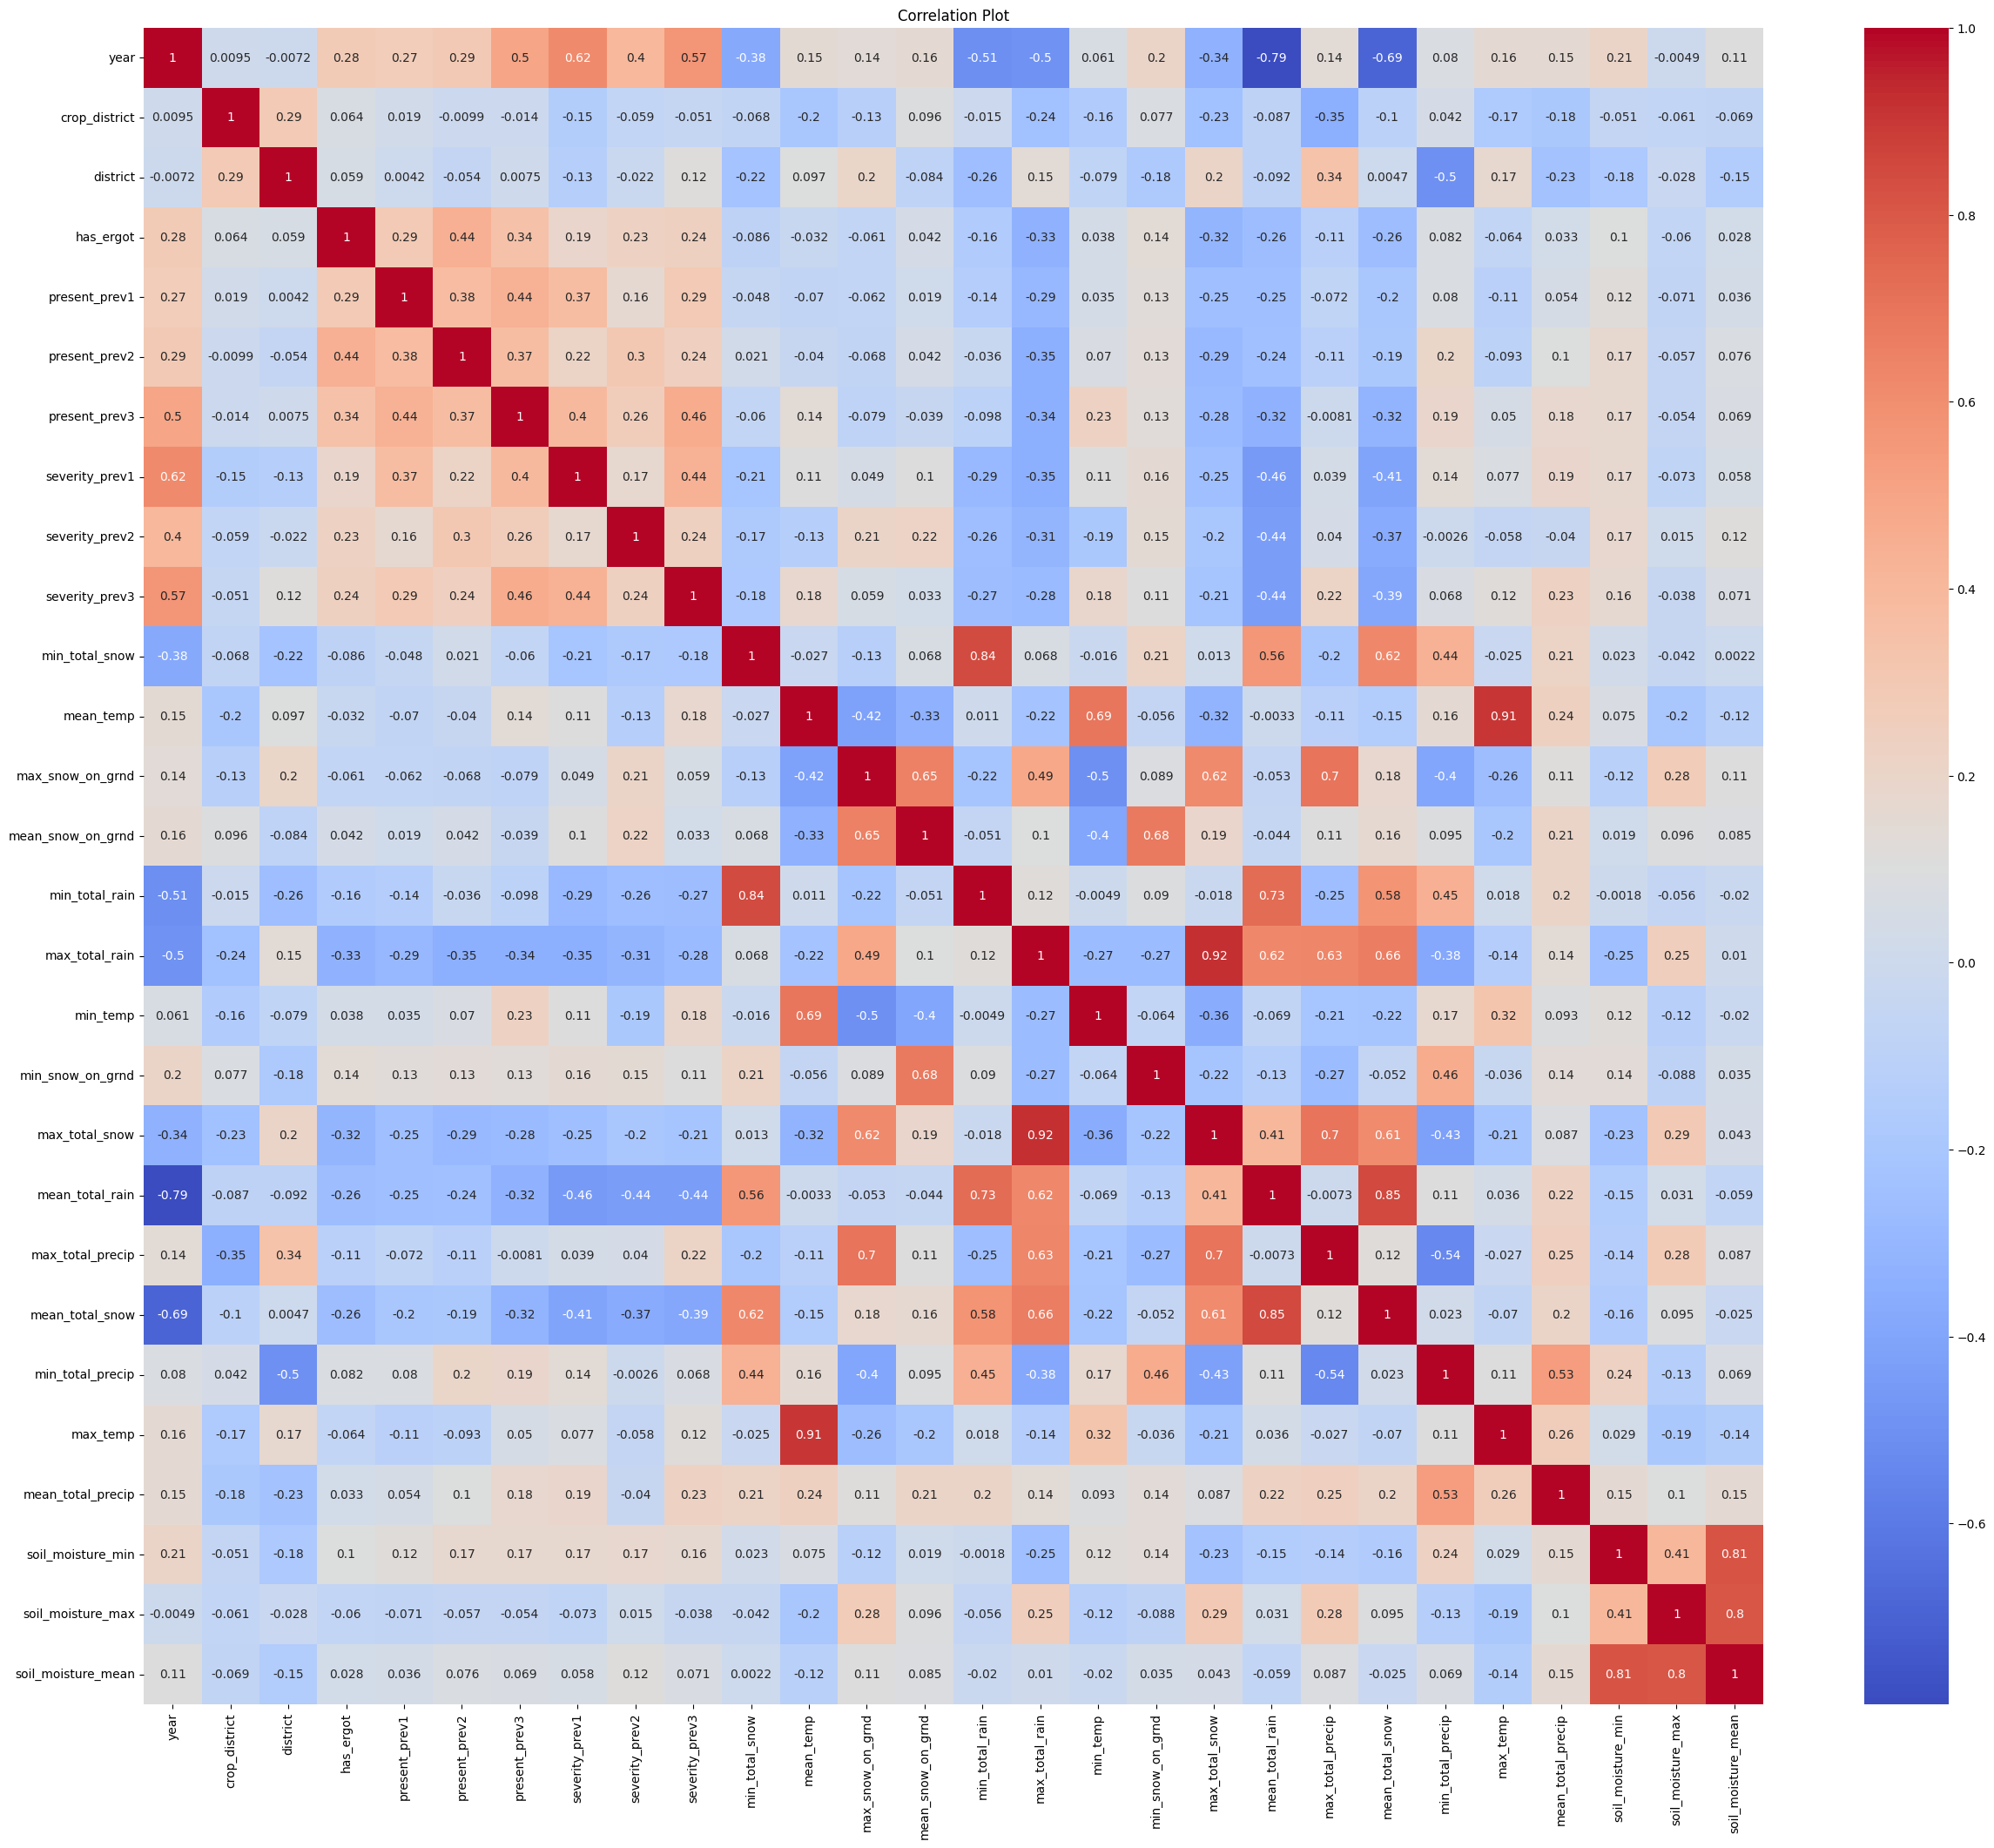

In [36]:
correlation_matrix = df.corr()
# Plot the correlation matrix as a heatmap
plt.figure(figsize=(30, 25))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True)
plt.title('Correlation Plot')
plt.show()

In [37]:
# with the following function we can select highly correlated features
# it will remove the first feature that is correlated with anything other feature

def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

In [38]:
corr_features = correlation(df, 0.8)
len(set(corr_features))
corr_features

/tmp/ipykernel_340236/3726835926.py:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = dataset.corr()


{'max_temp',
 'max_total_snow',
 'mean_total_snow',
 'min_total_rain',
 'soil_moisture_mean'}

In [39]:
# df.drop(columns=corr_features, inplace=True)

In [40]:
# using one hot encoding to change catagorical variable to numarical
df = pd.get_dummies(df, columns=["province"], drop_first=True)

In [41]:
df

,year,district,percnt_true,has_ergot,present_prev1,present_prev2,present_prev3,severity_prev1,severity_prev2,severity_prev3,...,min_total_snow,min_temp,mean_total_rain,max_snow_on_grnd,max_total_precip,min_total_rain,max_temp,soil_moisture_min,soil_moisture_max,soil_moisture_mean
0,1995,4810,0.000000,False,False,False,False,0.000000,0.000000,0.000000,...,0.0,-2.249689,0.328105,2.334247,2.528767,0.0,10.713096,0.14156,0.170067,0.150656
1,1995,4820,0.000000,False,False,False,False,0.000000,0.000000,0.000000,...,0.0,-2.722112,0.179473,1.893151,2.484110,0.0,10.926306,0.14156,0.170067,0.150656
2,1995,4830,0.010582,True,False,False,False,0.000000,0.000000,0.000000,...,0.0,-3.321827,0.332711,6.394521,5.339178,0.0,9.424064,0.14156,0.170067,0.150656
3,1995,4840,0.006017,True,False,False,False,0.000000,0.000000,0.000000,...,0.0,-4.348895,0.250507,7.876712,2.203836,0.0,7.595941,0.14156,0.170067,0.150656
4,1995,4850,0.006369,True,False,False,False,0.000000,0.000000,0.000000,...,0.0,-3.251098,0.531016,6.632877,3.216986,0.0,7.987340,0.14156,0.170067,0.150656
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65845,2022,4761,0.224490,True,True,True,True,0.010204,0.076923,0.062893,...,0.0,-3.774612,0.000000,5.383562,1.409589,0.0,8.882808,0.28157,0.281570,0.281570
65846,2022,4771,0.333333,True,False,True,True,0.000000,0.153333,0.013072,...,0.0,-4.853699,0.000000,3.216438,0.877260,0.0,7.748219,0.28157,0.281570,0.281570
65847,2022,4790,0.226891,True,True,True,True,0.025316,0.229167,0.147727,...,0.0,-5.284676,0.087452,19.868493,2.948767,0.0,7.079132,0.28157,0.281570,0.281570
65848,2022,4791,0.397260,True,True,True,True,0.028986,0.223881,0.328571,...,0.0,-5.094840,0.000000,19.161644,2.443288,0.0,7.411553,0.28157,0.281570,0.281570


# split data

In [43]:
X = df.drop(columns=["has_ergot"])
y = df['has_ergot']
oversampler = RandomOverSampler(random_state=42)
# y = df['has_ergot'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42, stratify=y)
print(y_train.value_count())
# X_train, y_train = oversampler.fit_resample(X_train, y_train)

TypeError: RandomOverSampler.__init__() got an unexpected keyword argument 'ratio'

In [77]:
y_

87926

In [78]:
# use StandardScaler when we don't know upper bounds
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [79]:
X_train_scaled.shape

(87926, 29)

In [80]:
tensorflow.config.set_visible_devices([], 'GPU')  # Hide GPU devices
tensorflow.config.set_visible_devices(tensorflow.config.list_physical_devices('CPU'), 'CPU')  # Show CPU devices


# creating model

In [81]:
model = Sequential()

model.add(Dense(6, activation="relu", input_dim = X.shape[1]))
# model.add(Dense(4, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

In [82]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 6)                 180       
                                                                 
 dense_3 (Dense)             (None, 1)                 7         
                                                                 
Total params: 187
Trainable params: 187
Non-trainable params: 0
_________________________________________________________________


In [83]:
# compile model
model.compile(loss="binary_crossentropy", optimizer="Adam", metrics=["accuracy"])

In [84]:
history = model.fit(X_train_scaled, y_train, epochs=40, validation_split=0.2, shuffle=True, batch_size=32)

Epoch 1/40
2199/2199 [==============================] - 2s 941us/step - loss: 0.3312 - accuracy: 0.8636 - val_loss: 0.2826 - val_accuracy: 0.9413
Epoch 2/40
2199/2199 [==============================] - 2s 910us/step - loss: 0.2029 - accuracy: 0.9418 - val_loss: 0.2110 - val_accuracy: 0.9873
Epoch 3/40
2199/2199 [==============================] - 2s 887us/step - loss: 0.1536 - accuracy: 0.9625 - val_loss: 0.1723 - val_accuracy: 0.9876
Epoch 4/40
2199/2199 [==============================] - 2s 911us/step - loss: 0.1251 - accuracy: 0.9733 - val_loss: 0.1431 - val_accuracy: 0.9902
Epoch 5/40
2199/2199 [==============================] - 2s 879us/step - loss: 0.1079 - accuracy: 0.9797 - val_loss: 0.1295 - val_accuracy: 0.9899
Epoch 6/40
2199/2199 [==============================] - 2s 913us/step - loss: 0.0959 - accuracy: 0.9823 - val_loss: 0.1312 - val_accuracy: 0.9897
Epoch 7/40
2199/2199 [==============================] - 2s 889us/step - loss: 0.0872 - accuracy: 0.9837 - val_loss: 0.1225 -

In [85]:
model.weights

[<tf.Variable 'dense_2/kernel:0' shape=(29, 6) dtype=float32, numpy=
 array([[-1.30677152e+00,  1.39522115e-02,  3.68220173e-02,
         -2.65315080e+00, -2.22331834e+00,  7.83339918e-01],
        [ 1.44187760e+00,  8.65225434e-01, -2.64912158e-01,
          5.40219307e-01, -5.92279792e-01,  6.13389552e-01],
        [-5.24584472e-01, -1.37879834e-01,  1.02081545e-01,
         -2.54394829e-01, -9.01226461e-01, -2.94836044e-01],
        [ 1.15477860e+00, -4.37086254e-01, -2.04544112e-01,
          3.16969752e-01,  1.98938000e+00,  6.99060082e-01],
        [ 9.95744616e-02,  1.49553943e+00,  2.31472701e-01,
          7.07543045e-02,  8.02176774e-01,  2.15853882e+00],
        [-2.03774989e-01,  2.09528953e-01, -6.71580315e-01,
          1.82679564e-01,  1.24363160e+00,  1.58445919e+00],
        [ 4.36985135e-01,  4.51581508e-01,  2.89538980e-01,
          2.12249085e-01, -5.81901558e-02,  2.32011482e-01],
        [ 3.37735891e-01,  6.49987936e-01,  1.11872077e+00,
          4.16565925e-01

In [86]:
y_pred = model.predict(X_test_scaled)

  1/403 [..............................] - ETA: 10s

403/403 [==============================] - 0s 439us/step


In [87]:
threshhold = 0.8
y_pred = np.where(y_pred > threshhold, True, False)

# y_test = y_test.to_numpy()
# type(y_pred)

In [88]:
accuracy_score(y_test, y_pred)

0.9944051596860672

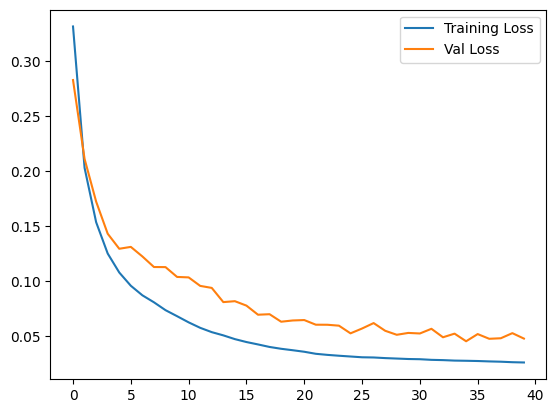

In [89]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.legend()

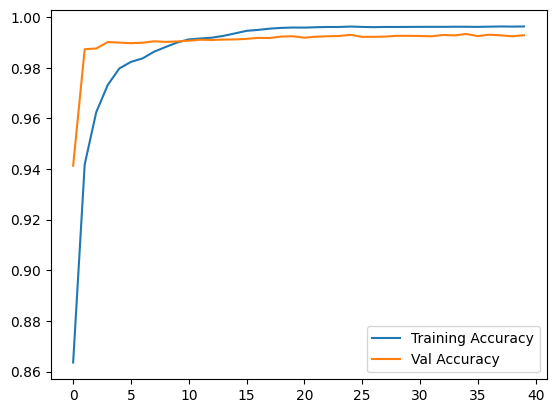

In [90]:
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.legend()

In [91]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.97      0.99      0.98      1878
        True       1.00      1.00      1.00     10991

    accuracy                           0.99     12869
   macro avg       0.99      0.99      0.99     12869
weighted avg       0.99      0.99      0.99     12869



0.9920888656213929


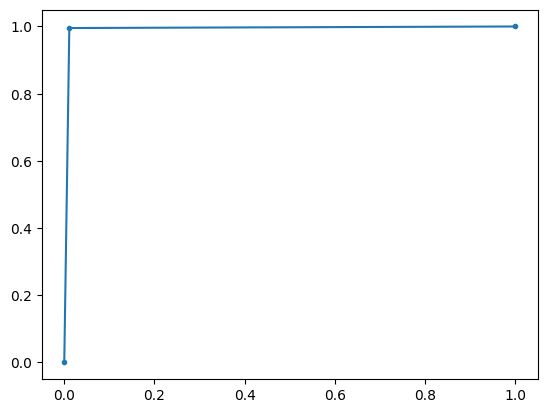

In [92]:
fpr, tpr, t = roc_curve(y_test, y_pred)
auc_ = auc(fpr, tpr)
plt.plot(fpr, tpr, marker=".")
print(auc_)